## MLP network for MNIST digits classification
In this example, we demonstrate how to build, train, and validate a model that classifies MNIST images.
Let us load the dataset first.

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import mnist

# load mnist dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# compute the number of labels
num_labels = len(np.unique(y_train))

## Pre-processing of data

The raw dataset is not ideal for training a machine learning model. The images are still in raw grayscale format wherein each pixel is $\epsilon [0,255]$. The labels are in raw digit format $\epsilon [0,9]$. Both input and output data must be pre-processed first.

### Convert raw labels into one-hot vector
The labels are in raw digit format (e.g. 0,1, ...,9). It is not ideal for computing the $y=f(x)=p(y|x)$ which is a mulitnoulli or categorical distribution. Therefore, the labels are converted into one-hot vector using `tf.keras` `to_categorical()` utility function.

In [3]:
# convert to one-hot vector
# e.g. 3 -> [0 0 0 1 0 0 0 0 0 0]
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

### Normalizing the pixel values
The pixel values (e.g. 0 to 255) is normalized to $[0.0, 1.0]$ so that the network can be easily trained. In other words, no wild fluctuations in weights in biases.

In [4]:
# image dimensions (assumed square)
image_size = x_train.shape[1]
input_size = image_size * image_size

# resize and normalize
x_train = np.reshape(x_train, [-1, input_size])
x_train = x_train.astype('float32') / 255
x_test = np.reshape(x_test, [-1, input_size])
x_test = x_test.astype('float32') / 255

### Hyper-parameters
A typical network has many hyper-parameters that we can tune.

`batch_size` is the number of samples used per SGD. There is no right value of `batch_size`. Usually, it ranges in the multiples of 2 (e.g 2, 4, 8, 16, 32, 64, 128, 256). The lower the `batch_size`, the more steps in SGD. Also, the less accurate is the estimate of the true gradient. The higher the value of `batch_size`, the less number of steps in SGD. The network might not be completely trained after the number of epochs indicated. High value leads to a better gradient estimate. This tradeoff let us choose a value of `128`. 

When processing huge data like big image sizes, the batch size is limited by the GPU memory of your PC.

One `epoch` means we have completed one training using the entire dataset. An `epoch` is equal to `len(x_train)/batch_size`.

`n_units` is simply the number of units of each MLP layer. For this example, we use a uniform number. However, this can have different numbers. In encoders, this number usually decreases with depth. In decoders, it is the reverse.

In [7]:
# hyper-parameters
batch_size = 128
n_units = 256
epochs = 20

### Model building
Let us build a 3-layer MLP. Each layer is a `Dense()` with `relu` activation. 

Since this is classifier, the last layer has number of units equal to the number of digit categories. The last layer uses a `softmax` activation to convert the prediction into probabilities. 

In [12]:
# model is a 3-layer MLP
model = Sequential(name='3-layer-MLP')
model.add(Dense(n_units, input_dim=input_size, activation='relu', name='input_layer'))
model.add(Dense(n_units, activation='relu', name='hidden_layer'))
model.add(Dense(num_labels, activation='softmax', name='output_layer'))
model.summary()


Model: "3-layer-MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 256)               200960    
_________________________________________________________________
hidden_layer (Dense)         (None, 256)               65792     
_________________________________________________________________
output_layer (Dense)         (None, 10)                2570      
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
_________________________________________________________________


## Training and evaluation (testing)

Let's train the model using SGD and let's monitor one important metric in classification - `accuracy`. At every epoch, we conduct a validation in order to see if there is an improvement in test accuracy.

In [14]:
# loss function for one-hot vector
# use of sgd optimizer with default lr=0.01
# accuracy is a good metric for classification tasks
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
# train the network
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size)

# validate the model on test dataset to determine generalization
loss, acc = model.evaluate(x_test,
                           y_test, 
                           batch_size=batch_size,
                           verbose=False)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

Epoch 1/20
469/469 [==============================] - 1s 3ms/step - loss: 1.2387 - accuracy: 0.6988 - val_loss: 0.5954 - val_accuracy: 0.8560
Epoch 2/20
469/469 [==============================] - 1s 3ms/step - loss: 0.4945 - accuracy: 0.8727 - val_loss: 0.4006 - val_accuracy: 0.8911
Epoch 3/20
469/469 [==============================] - 1s 2ms/step - loss: 0.3845 - accuracy: 0.8954 - val_loss: 0.3421 - val_accuracy: 0.9025
Epoch 4/20
469/469 [==============================] - 1s 3ms/step - loss: 0.3393 - accuracy: 0.9048 - val_loss: 0.3098 - val_accuracy: 0.9118
Epoch 5/20
469/469 [==============================] - 1s 2ms/step - loss: 0.3112 - accuracy: 0.9121 - val_loss: 0.2879 - val_accuracy: 0.9179
Epoch 6/20
469/469 [==============================] - 1s 2ms/step - loss: 0.2906 - accuracy: 0.9173 - val_loss: 0.2721 - val_accuracy: 0.9216
Epoch 7/20
469/469 [==============================] - 1s 2ms/step - loss: 0.2741 - accuracy: 0.9221 - val_loss: 0.2577 - val_accuracy: 0.9255
Epoch 

### Examine the train history

Let's examine how the loss (cross-entropy) improves with epochs. 

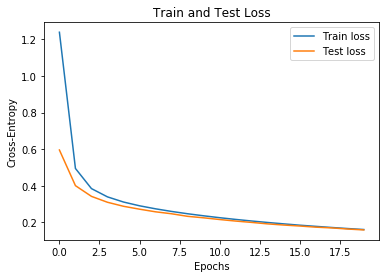

In [20]:
import matplotlib.pyplot as plt

# Plot history: Loss and accuracy
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
#plt.plot(history.history['val_acc'], label='Test accuracy')
plt.title('Train and Test Loss')
plt.ylabel('Cross-Entropy')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

## Train and test accuracy

Ideally, as the train performance improves, the test accuracy improves. In general, this does not happen.

There are situations when the train and accuracy both improve up to a certain only. Then, the test accuracy degrades while the train accuracy is still improving. This situation is called overfitting. The network is no longer learning but just memorizing the train data. 

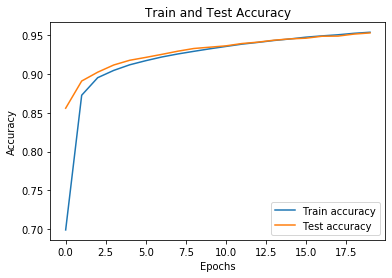

In [21]:
# Plot history: Loss and accuracy
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Test accuracy')
#plt.plot(history.history['val_acc'], label='Test accuracy')
plt.title('Train and Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc="lower right")
plt.show()